## Meas/Coords Validation

This goal of this Notebook is to show that real data can be mapped on Measure classes and that the Measure object quantities can be retrieved by generice code.

We proceed with data mapped on individual Measure objects in order to avoid bias possibly introduced by some host model.

This workflow validates the [Measure](https://github.com/ivoa/modelinstanceinvot-code) model (and its coordinates(https://github.com/ivoa-std/CoordinateDM)) in the extand of the the implemented classes.

### Test Case

The VOtable has been queried from tme ESAC XMM TAP archive with the following query:
```
SELECT TOP 10 xsa.v_epic_source_cat.date_obs , xsa.v_epic_source_cat."dec" , xsa.v_epic_source_cat.ep_hr1 , xsa.v_epic_source_cat.ep_hr1_err , xsa.v_epic_source_cat.ep_hr2 , xsa.v_epic_source_cat.ep_hr2_err , xsa.v_epic_source_cat.ep_hr3 , xsa.v_epic_source_cat.ep_hr3_err , xsa.v_epic_source_cat.ep_hr4 , xsa.v_epic_source_cat.ep_hr4_err , xsa.v_epic_source_cat.iauname , xsa.v_epic_source_cat.ra
 FROM  xsa.v_epic_source_cat
 WHERE ( xsa.v_epic_source_cat.iauname = '4XMM J174544.4-290024' )
```

We select the positions and the observation dates of the '4XMM J174544.4-290024' source as well as its hardness ratios. 
This source is located near the galactic center, so we can expect these parameters to vary along of the observations covering 20 years.

- We are using the annotation [syntax](https://github.com/ivoa-std/ModelInstanceInVot) that has been designed after the 2021 workshop.
- The Python code used for this notebook is being [developped](https://github.com/ivoa/modelinstanceinvot-code) to design qnd validate the processing of model annotation.


### Package Init
- Import packages
- Set the data directory
- Print to check

In [1]:
import sys
import unittest
import os
import logging
import matplotlib
import mplcursors
import matplotlib.pyplot as plt 
import numpy as np
from astropy.io.votable import parse

base_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(base_dir, "mivot_code", "examples", "data/")

print(os.getcwd())
print(base_dir)
print(data_dir)
sys.path.append(os.path.realpath(base_dir))

from mivot_code.client.xml_interpreter.model_viewer import ModelViewer


/Users/laurentmichel/Documents/seafile/Seafile/workspaces/git/modelinstanceinvot-code/jupyter
/Users/laurentmichel/Documents/seafile/Seafile/workspaces/git/modelinstanceinvot-code
/Users/laurentmichel/Documents/seafile/Seafile/workspaces/git/modelinstanceinvot-code/mivot_code/examples/data/
   INFO - [__init__.py:  7 -   <module>()] - utils package initialized
   INFO - [__init__.py: 16 -   <module>()] - client package intialized
   INFO - [__init__.py: 14 -   <module>()] - translator package intialized


## VOTable parsing
The VOTable is parsed by Astropy as usual

In [2]:
votable = parse(os.path.join(data_dir, "xmm_move_hr.xml"))

## Building the Model Viewer
The model viewer wrapps the VOTable data iterator to provide model views of the current data raw
The model viewer supports 3 serializations:
- XML
- JSON 
- STC components (used here)

In the future, the resource selection should be handled by the either Astropy or PyVO, but meanwhile this is not implemented, the job is done by hand. 
We assume that the 1st resource is annotated.

In [3]:
for resource in votable.resources:
    mviewer = ModelViewer(resource, votable_path=os.path.join(data_dir, "xmm_move_hr.xml"))
    break

   INFO - [model_viewer.py:402 - _extract_mapping_block()] - extract vodml block from /Users/laurentmichel/Documents/seafile/Seafile/workspaces/git/modelinstanceinvot-code/mivot_code/examples/data/xmm_move_hr.xml
   INFO - [annotation_seeker.py: 38 -   __init__()] - Found GLOBALS
   INFO - [annotation_seeker.py: 46 -   __init__()] - Found TEMPLATES Results
   INFO - [model_viewer.py:416 - _extract_mapping_block()] - VODML found


## Connecting the Data table we Want to Browse
In this example we just have one table that is annotated. 
- We assume we will work on data of this table
- We do not look for complex objects that could be located in some other tables or in the GLOBALS block 

In [4]:
mviewer.connect_table('Results')


  DEBUG - [model_viewer.py:203 - connect_table()] - table Results found in VOTable
  DEBUG - [model_viewer.py:208 - connect_table()] - TEMPLATES Results found 


## Using Data Model Views
The model viewer iterate over the data row by using the Astropy parser. The last read row is stored internally to get available to be processed by the viewer.

In the current the example, we know that each data rows contains one position, one time stamp and 4 hardness ratios. The viewer provides tools to discover these quantities, but  this is not the purpose of the exercise. 

For each row, we extract Measures instances of those quantities and we store them in Python lists ready to be displayed by matplotlib.

The point here is that the code just processes data annotations. It has no feature specific for that VOTable.

In [5]:
times = []
ras = []
decs = []
mviewer.rewind()
while True:
    row = mviewer.get_next_row() 
    if row is None:
        break  
            
    position = mviewer.get_stc_positions()[0]
    ras.append(position.coord.lon.value)    
    decs.append(position.coord.lat.value)   
            
    hr = mviewer.get_stc_generic_measures()

    times.append(f"Obs time: {mviewer.get_stc_times()[0].coord.datetime}"\
                f"\nra:{position.coord.lon.value}"\
                f"\ndec: {position.coord.lat.value}"
                f"\nhr1: {hr[0].coord.cval} +/- {hr[0].error.radius}"\
                f"\nhr2: {hr[1].coord.cval} +/- {hr[1].error.radius}"\
                f"\nhr3: {hr[2].coord.cval} +/- {hr[2].error.radius}"\
                f"\nhr4: {hr[3].coord.cval} +/- {hr[3].error.radius}"
                ) 

## Data Normalization

The data contains 10 position of one XMM source taken over 20 year. To make the plot more readable, we transform the positions as deltas from the mean value.

In [6]:
ram = 0.0
for ra in ras:
    ram += ra
ram /= len(ras)
decm = 0.0
for dec in decs:
    decm += dec
decm /= len(decs)
for i in range(len(ras)):
    ras[i] = 3600*(ras[i] - ram)
    decs[i] = 3600*(decs[i] - decm)


## Matplotlib setup

Since we have a 7 dimensions dataset (position, time and 4 HRs), we use tooltips to represent it in a convinient way.
Matplotlib must be setup accordingly

In [7]:
%matplotlib widget

  DEBUG - [pyplot.py:280 - switch_backend()] - Loaded backend module://ipympl.backend_nbagg version unknown.


## Lets plot

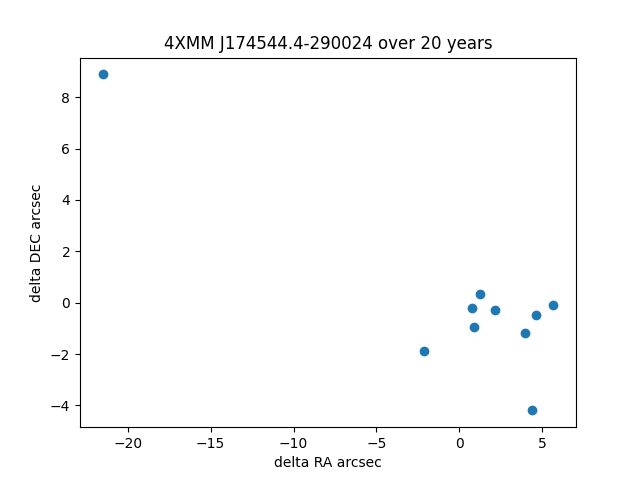

In [8]:
matplotlib.font_manager: logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)
plt.scatter(ras, decs)
plt.title("4XMM J174544.4-290024 over 20 years")
plt.xlabel("delta RA arcsec")
plt.ylabel("delta DEC arcsec")
mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(times[sel.index]))
        
plt.show()